<a href="https://colab.research.google.com/github/lin3372/400_gan/blob/main/400_gan_248_keras_implementation_of_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[github(bnsreenu) - 248_keras_implementation_of_GAN](https://github.com/bnsreenu/python_for_microscopists/blob/master/248_keras_implementation_of_GAN/248-cifar_GAN.py)

[youtube (31min) - 248_keras_implementation_of_GAN](https://www.youtube.com/watch?v=TXy5wZknie8)

[Machinelearningmastery - How to Develop a GAN to Generate CIFAR10 Small Color Photographs](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

# Library, Parameters

In [1]:
import numpy as np
import tensorflow as tf
import random as rand
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import  plot_model

from matplotlib import pyplot
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [2]:
FIG_SIZE=(6,6)
INPUT_IMG_SZ=(32,32,3)

# Topics of Content

Topics in this tutorials:
0. GAN Introduction
1. CIFAR-10 Small Object Photograph Dataset
2. How to Define and Train the Discriminator Model
3. How to Define and Use the Generator Model
4. How to Train the Generator Model
5. How to Evaluate GAN Model Performance
6. Complete Example of GAN for CIFAR-10
7. How to Use the Final Generator Model to Generate Images

# **0. GAN (Generative Adversarial Networks)** Introduction - Basic ideas

Generative Adversarial Networks, or GANs, are an architecture for training generative models, such as deep convolutional neural networks for generating images.

Developing a GAN for generating images requires both 
1. **Discriminator** convolutional neural network model for classifying whether a given image is real or generated, and 
2.  **Generator** model that uses inverse convolutional layers to transform an input to a full two-dimensional image of pixel values.

It can be challenging to understand both how GANs work and how deep convolutional neural network models can be trained in a GAN architecture for image generation. A good starting point for beginners is to practice developing and using GANs on standard image datasets used in the field of computer vision, such as the CIFAR small object photograph dataset. The code by **Jason Brownlee** from his blogs on https://machinelearningmastery.com/

* Regular **GAN** that generates images using a random latent vector as input.
* While it works great we do not know the mapping of latent vector to the generated image.
* **Conditional GANs** can be used to supply a label during taining so the latent vector can be associated with a specific label - making the generation of images predictable. 


Expected Takeaway:

1. How to define and train the standalone **Discriminator model** for learning the difference between real and fake images.
2. How to define the standalone **Generator model** and train the composite generator and discriminator model.
3. How to evaluate the performance of the GAN and use the final standalone generator model to generate new images.

# **1. CIFAR-10 Small Object Photograph Dataset**



**CIFAR* is an acronym for the Canadian Institute For Advanced Research and the CIFAR-10 dataset was developed along with the CIFAR-100 dataset by researchers at the CIFAR institute.

The dataset is comprised of 60,000 32×32 pixel color photographs of objects from 10 classes, such as frogs, birds, cats, ships, airplanes, etc.

Keras provides access to the CIFAR10 dataset via the **cifar10.load_dataset()** function. It returns two tuples, one with the input and output elements for the standard training dataset, and another with the input and output elements for the standard test dataset.

## Load Cifar10 and plot to get a quick understanding
Note: the first time you load the dataset, Keras will automatically download a compressed version of the images and save them under your home directory in **~/.keras/datasets**

CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

170508288/170498071 [==============================] - 4s 0us/step
Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


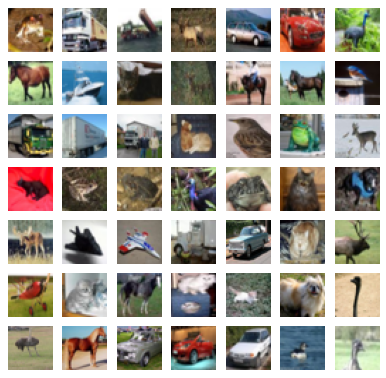

In [3]:
# example of loading the cifar10 dataset
from keras.datasets.cifar10 import load_data
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot

# CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()

# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

# plot images from the training dataset
figure(figsize=FIG_SIZE, dpi=80)
for i in range(49):
	# define subplot
	pyplot.subplot(7, 7, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i])
 
pyplot.show()

## 1.1 Images for training - 
### **half batch of real images and half batch of fake images**
Pick a batch of random real samples to train the GAN

In fact, we will train the GAN on a half batch of real images (label 1) and another half batch of fake images (label 0) 



### select real samples for each batch'ed **Discriminator** training

The *generate_real_samples()* function below will take the training dataset as an argument and will select a random subsample of images; 

it will also return class labels for the sample, specifically a class label of 1, to indicate real images.

In [4]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

## latent vectors as input for the generator
Generate n_samples number of latent vectors as input for the generator


In [5]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

## Generator to generate fake images, with class labels
* Supply the generator, latent_dim and number of samples as input.

* Use the above generate_latent_points() to generate latent points. 


In [6]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples. 
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake. 
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y

#**Generator**, **Discriminator**, **GAN**, **Train()** and other **Helper** functions
Using Sequential method from Keras as it makes the definition of models easy.

We will use functional way of defining the model for the conditional gan but sequential for descriminator and generator as they are straightforward.


# **1. Discriminator Model** - How to Define and Train

The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake. This is a **binary classification** problem.

* Inputs: Image with three color channel and 32×32 pixels in size.
* Outputs: Binary classification, likelihood the sample is real (or fake).

## **Discriminator** model definition
Given an input image, the Discriminator outputs the likelihood of the image being real.




The discriminator model has 
1. a normal convolutional layer 
2. followed by three convolutional layers using a stride of 2×2 to downsample the input image. 
3. The model has no pooling layers, and  
4. a single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. 
5. The model is trained to minimize the **binary cross entropy loss function**, appropriate for binary classification.
> Binary classification - true or false (1 or 0). So using sigmoid activation.



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8

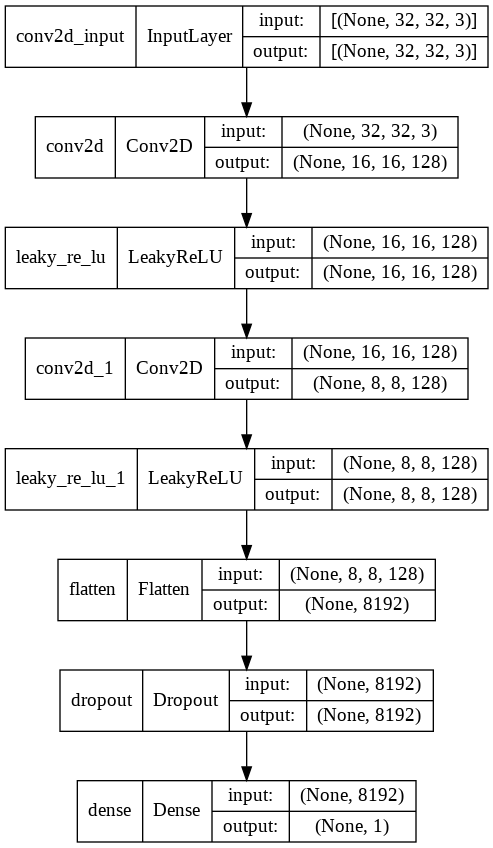

In [7]:
def define_discriminator(in_shape=INPUT_IMG_SZ):
	model = Sequential()
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) 
	model.add(LeakyReLU(alpha=0.2))
  # outputs become 16x16x128
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) # 8x8x128
	model.add(LeakyReLU(alpha=0.2))
  # output become 8x8x128
	
	model.add(Flatten()) #shape of 8192
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid')) #shape of 1

	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 
	# summarize the model
	model.summary()
	
	# plot the model
	plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

	return model

test_discr = define_discriminator()
print(test_discr.summary())
plot_model(test_discr, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)


### print(test_discr.summary())
### define model
### model = define_discriminator()
### summarize the model
### model.summary()
### plot the model
### plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)
###

## **Images for Discriminator training** 
> **half real images and half fake images for each batch**

Pick a batch of random real samples to train the GAN

In fact, we will train the GAN on a half batch of real images (label 1) and another half batch of fake images (label 0) 

### ***real images*** samples from loaded cifar10 image database

We must scale the pixel values from the range of unsigned integers in [0,255] to the normalized range of [-1,1].

The generator model will generate images with pixel values in the range [-1,1] as it will use the  *$tanh()$*  activation function, a best practice.

*generate_real_samples():*
* The *generate_real_samples()* function will take the training dataset as an argument and will select a random subsample of images; 
* It will also return class labels for the sample, specifically a class label of 1, to indicate real images.

In [8]:
# load cifar training images
def load_real_samples():
	(trainX, _), (_, _) = load_data()
 
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
 
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5  
  #Generator uses tanh activation so rescale original images to -1 to 1 to match the output of generator.
	return X

The model will be updated in batches, specifically with a collection of real samples and a collection of generated samples. 
> On training, an epoch is defined as one pass through the entire training dataset.

We could systematically enumerate all samples in the training dataset, and that is a good approach, but ,
> good training via **stochastic gradient descent** requires that the training dataset be shuffled prior to each epoch. 
> A simpler approach is to select random samples of images from the training dataset.

In [9]:
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) ##Label=1 indicating they are real
	return X, y

### ***fake image*** samples for Discriminator training

We can generate images comprised of random pixel values, specifically random pixel values in the range [0,1], then scaled to the range [-1, 1] like our scaled real images. The generator model will generate images with pixel values in the range [-1,1] as it will use the  **$tanh()$**  activation function, a best practice.

The ***generate_fake_samples()*** function below implements this behavior and generates images of random pixel values and their associated class label of 0, for fake.

In [10]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = np.random.rand(32 * 32 * 3 * n_samples)
 
	# update to have the range [-1, 1]
	X = -1 + X * 2

	# reshape into a batch of color images
	X = X.reshape((n_samples, 32, 32, 3))
 
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))

	return X, y

In [11]:
#### testing code for random numbers 
"""
x = random.uniform(0,1)
print(x)

T = np.random.rand(3 * 3 * 2)
print(f"T={T}")
"""

'\nx = random.uniform(0,1)\nprint(x)\n\nT = np.random.rand(3 * 3 * 2)\nprint(f"T={T}")\n'

## **Discriminator** model training

The model will learn to discriminate between real and fake (randomly generated) images rapidly.

The **train_discriminator()** function implements this, using a batch size of 128 images, where 64 are real and 64 are fake each iteration.

We update the discriminator separately for real and fake examples so that we can calculate the accuracy of the model on each sample prior to the update. This gives insight into how the discriminator model is performing over time.

In [12]:
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
	half_batch = int(n_batch / 2)
 
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples and update discriminator on real samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		_, real_acc = model.train_on_batch(X_real, y_real)
  
		# generate 'fake' examples and update discriminator on fake samples
		X_fake, y_fake = generate_fake_samples(half_batch)
		_, fake_acc = model.train_on_batch(X_fake, y_fake)

		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [13]:
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_1 (Dropout)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                

# **2. Generator** model
Given input of **latent vector**, the Generator produces an image.(here: 32x32) ***latent_dim***, for example, can be 100, 1D array of size 100 

   

The generator model is responsible for creating new, fake, but plausible small photographs of objects.

It does this by taking a point from the latent space as input and outputting a square color image.

The latent space is an arbitrarily defined vector space of **Gaussian-distributed** values, e.g. 100 dimensions. It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points and, in turn, the latent space, until, at the end of training, the latent vector space represents a compressed representation of the output space, CIFAR-10 images, that only the generator knows how to turn into plausible CIFAR-10 images.

* Inputs: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.
* Outputs: Two-dimensional square color image (3 channels) of 32 x 32 pixels with pixel values in [-1,1].

Here we are only using Dense and conv2dlayers. But network can be complicated based on the application. For example, you can use VGG for super res. GAN.

In [ ]:
def define_generator(latent_dim):    
  #latent_dim is the dimension of the latent vector (e.g., 100)
	model = Sequential()
	# We will reshape input latent vector into 8x8 image as a starting point. 
  # So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
  # it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.

	n_nodes = 128 * 8 * 8   #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector. 
	
  # upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3

	return model  #Model not compiled as it is not directly trained like the discriminator.
                #Generator is trained via GAN combined model. 

test_gen = define_generator(100)
print(test_gen.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                            

## **GAN - Combined Generator and Discriminator** model
* For updating the Generator
* Discriminator is trained separately so here only generator will be trained by keeping the discriminator constant. 


In [ ]:
def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

## **train() - for Generator and Discriminator**
looping through a number of epochs to train our Discriminator by 


1.   Selecting a random batch of images from our true/real dataset
2.   Generating a set of images using the generator
3.   Feed both set of images into the Discriminator
4.   Set the loss parameters for both the real and fake images, as well as the combined loss.


In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128, f_model="gan_model"):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  
  # the discriminator model is updated for a half batch of real samples 
  #   and a half batch of fake samples, combined a single batch. 
	
  # manually enumerate epochs and bacthes. 
	for i in range(n_epochs):
		# enumerate batches over the training set

		for j in range(bat_per_epo):
      # Train the discriminator on real and fake images, separately (half batch each)
      # Research showed that separate training is more effective. 
			
      # get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
      ## train_on_batch allows you to update weights based on a collection of samples you provide
            
      #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
			
      # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			
      # update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
      #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
      # Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
             
      # The generator wants the discriminator to label the generated samples as valid (ones)
      # This is where the generator is trying to trick discriminator into believing
      #   the generated image is true (hence value of 1 for y)			
			y_gan = ones((n_batch, 1))
            
      # Generator is part of combined model where it got directly linked with the discriminator
      # Train the generator with latent_dim as x and 1 as y. 
      # Again, 1 as the output as it is adversarial and if generator did a great job 
      #     of following the discriminator then the output would be 1 (true)
			
      # update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			
      # Print losses on this batch
			if (j % (int(bat_per_epo/10)) == 0):
			  print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' \
          %(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

    # save the generator model after each epoch
    #g_model.save('cifar_generator_2epochs.h5')
		g_model.save(f"{f_model}.{i+1}_{n_epochs}.h5")

	# save the generator model
	g_model.save(f"{f_model}_final.h5")
	#g_model.save('cifar_generator_2epochs.h5')

# GAN training

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=500, f_model="cifar_gan")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch>1, Batch 1/390, d1=0.711, d2=0.696 g=0.690
Epoch>1, Batch 40/390, d1=0.247, d2=0.883 g=0.683
Epoch>1, Batch 79/390, d1=0.094, d2=0.547 g=1.004
Epoch>1, Batch 118/390, d1=1.707, d2=0.892 g=1.825
Epoch>1, Batch 157/390, d1=0.145, d2=0.576 g=1.013
Epoch>1, Batch 196/390, d1=0.511, d2=0.331 g=1.559
Epoch>1, Batch 235/390, d1=0.448, d2=0.604 g=1.667
Epoch>1, Batch 274/390, d1=0.633, d2=0.450 g=1.269
Epoch>1, Batch 313/390, d1=0.552, d2=0.575 g=0.971
Epoch>1, Batch 352/390, d1=0.584, d2=0.834 g=0.743
Epoch>2, Batch 1/390, d1=0.879, d2=0.676 g=0.911
Epoch>2, Batch 40/390, d1=0.811, d2=0.626 g=0.954
Epoch>2, Batch 79/390, d1=0.665, d2=0.386 g=1.320
Epoch>2, Batch 118/390, d1=0.702, d2=0.817 g=0.666
Epoch>2, Batch 157/390, d1=0.619, d2=0.776 g=0.709
Epoch>2, Batch 196/390, d1=0.655, d2=0.642 g=0.809
Epoch>2, Batch 235/390, d1=0.695, d2=0.727 g=0.755
Epoch>2, Batch 274/390, d1=0.790, d2=0.700 g=0.849
Epoch>2, Batch 313/390, d1=0.765, d2=0.634 g=0.859
Epoch>2, Batch 352/390, d1=0.717, d2=0.

# Generator model - image generation 

In [ ]:
import numpy as np
from keras.models import load_model
from numpy.random import randn
from matplotlib.pyplot import figure

# Plot generated images 
def show_plot(examples, n):
  figure(figsize=(8, 8), dpi=80)
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i, :, :, :])
  plt.show()

# load model
model = load_model('/content/cifar_gan_final.h5') 
# Model trained for 100 epochs

# generate images
latent_points = generate_latent_points(100, 25)  
#Latent dim and n_samples

# generate images
X = model.predict(latent_points)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)

#Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck

In [ ]:
import os

os.getcwd()